In [161]:
import numpy as np
import regex as re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import requests

url_test = 'https://oda.ft.dk/api/Afstemning?$expand=Sagstrin/Sag&$filter=vedtaget eq true&$inlinecount=allpages'

r = requests.get(url_test)

sager = r.json()

In [3]:
#This function takes dict, extracts the next link, gets the new dict and appends it to the old dict

def get_all_pages(url):

    r = requests.get(url)

    sager = r.json()
    prev = r.json()

    while 'odata.nextLink' in prev:

        r = requests.get(prev['odata.nextLink'])
        sager['value'] += r.json()['value']
        prev = r.json()

    return sager

In [4]:
sager = get_all_pages(url_test)
sager.keys()

dict_keys(['odata.metadata', 'odata.count', 'value', 'odata.nextLink'])

In [5]:
#checking if all sager have the same keys
test = [len(sager['value'][i].keys()) for i in range(len(sager['value']))]
np.unique(test)

array([ 9, 10])

In [6]:
#they don't, so we check how many sager have missing keys
missing_keys = [i for i in range(len(sager['value'])) if len(sager['value'][i].keys()) != 10]
missing_keys

[0,
 1099,
 1100,
 1327,
 1404,
 1531,
 1532,
 1533,
 1542,
 1544,
 1550,
 1556,
 1559,
 1560]

In [7]:
#the above is only 14, so we remove those sager
clean_sager = [sag for sag in sager['value'] if len(sag) == 10]

In [8]:
clean_sager[0]['id']

2

In [9]:
clean_sager[0]['Sagstrin']['Sag'].keys()


dict_keys(['id', 'typeid', 'kategoriid', 'statusid', 'titel', 'titelkort', 'offentlighedskode', 'nummer', 'nummerprefix', 'nummernumerisk', 'nummerpostfix', 'resume', 'afstemningskonklusion', 'periodeid', 'afgørelsesresultatkode', 'baggrundsmateriale', 'opdateringsdato', 'statsbudgetsag', 'begrundelse', 'paragrafnummer', 'paragraf', 'afgørelsesdato', 'afgørelse', 'rådsmødedato', 'lovnummer', 'lovnummerdato', 'retsinformationsurl', 'fremsatundersagid', 'deltundersagid'])

In [10]:
#This function takes an id for a vote and collects all the votes for that vote

def get_all_votes(id):
    url = f'https://oda.ft.dk/api/Afstemning({id})/Stemme?$inlinecount=allpages'
    r = requests.get(url)
    votes = r.json()
    prev = r.json()
    while 'odata.nextLink' in prev:
        r = requests.get(prev['odata.nextLink'])
        votes['value'] += r.json()['value']
        prev = r.json()
        
    return votes


votes_test = get_all_votes(clean_sager[0]['id'])

In [11]:
votes_test['value']

[{'id': 180,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 158,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 181,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 126,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 182,
  'typeid': 2,
  'afstemningid': 2,
  'aktørid': 71,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 183,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 50,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 184,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 49,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 185,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 220,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 186,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 183,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 187,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 85,
  'opdateringsdato': '2014-09-09T09:25:05.717'},
 {'id': 188,
  'typeid': 1,
  'afstemningid': 2,
  'aktørid': 303,
  'opdate

In [12]:
#takes stemme-id which is id in stemme and returns info on the specific politician

#THIS DOES NOT WORK FOR ALL POLITICIANS
def get_politician(id):
    
        url = f'https://oda.ft.dk/api/Stemme({id})/Akt%C3%B8r?$expand=Parti'
        r = requests.get(url)

        raw =  r.json()
        
        politician = dict()
        politician['navn'] = raw['navn']        
        party = re.search("<party>(.*?)<\/party>", raw['biografi']).group(1)
        politician['party'] = party

        return politician



        # we are only interested in typeid: 5, which is a person

test = get_politician(1)

test

{'navn': 'Eigil Andersen', 'party': 'Socialistisk Folkeparti'}

In [56]:
import pandas as pd
import numpy as np


import pandas as pd
def law_info(data):
    df = pd.DataFrame()

    df['afstemnings_id'] = [x['id'] for x in data]
    df['sagstrin_id'] = [x['sagstrinid'] for x in data]
    df['vedtaget'] = [x['vedtaget'] for x in data]
    df['dato'] = [x['opdateringsdato'] for x in data]
    df['sag_id'] = [x['Sagstrin']['Sag']['id'] for x in data]
    df['titel']= [x['Sagstrin']['Sag']['titel'] for x in data]
    df['titel_kort'] = [x['Sagstrin']['Sag']['titelkort'] for x in data]
    df['lovnummer_num'] = [x['Sagstrin']['Sag']['nummernumerisk'] for x in data]
    df['lovnummer'] = [x['Sagstrin']['Sag']['nummer'] for x in data]
    df['resume']= [x['Sagstrin']['Sag']['resume'] for x in data]
    df['periode_id']= [x['Sagstrin']['Sag']['periodeid'] for x in data]

    return df
    

        
law_info = law_info(clean_sager)
law_info.head()

,afstemnings_id,sagstrin_id,vedtaget,dato,sag_id,titel,titel_kort,lovnummer_num,lovnummer,resume,periode_id
0,2,4849,True,2014-09-09T09:25:05.717,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32
1,3,17351,True,2018-01-24T16:46:33.99,5604,"Folketinget konstaterer, at Danmark stod dårli...",Om rigets tilstand.,2,V 2,,31
2,4,18370,True,2018-01-25T10:25:25.64,5904,Forslag til lov om akutjob og jobpræmie til ar...,Om akutjob.,46,L 46,"Med loven etableres en midlertidig ordning, så...",31
3,5,4849,True,2017-08-10T12:57:52.27,1449,Forslag til lov om ændring af virksomhedsskatt...,Om indgreb mod utilsigtet udnyttelse af virkso...,200,L 200,Loven ændrer virksomhedsskatteordningens regle...,32
4,6,16581,True,2017-08-10T12:57:52.257,5384,Forslag til folketingsbeslutning om dansk mili...,Om dansk militært bidrag til støtte for indsat...,122,B 122,Med folketingsbeslutningen giver Folketinget s...,32


In [14]:
#This function takes in a df of each vote and makes a dataframe of all the votes for each vote
#### WORK IN PROGRESS ####
def votes_df(voting_df):
    df = pd.DataFrame()

    #typeid: 1=ja, 2=nej, 3=blank, 4=fraværende

    df["afstemnings_id"] = voting_df["afstemnings_id"].values
    df["votes_combined_info"] = [get_all_votes(x)['value'] for x in voting_df['afstemnings_id']] #creates a dict
    

    return df



    


In [ ]:
#pickle dataframe
#import pickle
#
#with open('votes_df.pickle', 'wb') as f:
#    pickle.dump(votes_df, f)


In [49]:
import pickle
### This is the code to load the dataframes from a pickle file file
with open('votes_df.pickle', 'rb') as handle:
    vote_info = pickle.load(handle)

In [ ]:
#votes_df = votes_df(df_voting)
#Takes a while to run, so we load it from a pickle file

In [ ]:
#trying to count how many voted yes in total, not currently working...
count = 0
for i in range(len(votes_df["votes_combined_info"])):
    for j in votes_df["votes_combined_info"][i][j]:
        print(j)
        if votes_df["votes_combined_info"][i][j]['typeid'] == 1:
            count += 1
    print(i)


TypeError: list indices must be integers or slices, not str

In [87]:
#Get all unique aktør-id's
aktør_id = []
for i in range(len(vote_info["votes_combined_info"])): #for each vote
    for j in range(len(vote_info["votes_combined_info"][i])): #for each vote
        aktør_id.append(vote_info["votes_combined_info"][i][j]['aktørid'])
        

In [90]:
unique_politicians = np.unique(aktør_id)

In [91]:
len(unique_politicians)

615

In [97]:
#Find earliest and latest law passed:
#earliest
earliest = law_info['dato'].min()
latest = law_info['dato'].max()
print(f"Earliest law passed in dataset was on {earliest}")
print(f"Latest law passed in dataset was on {latest}")

Earliest law passed in dataset was on 2014-09-09T09:25:05.717
Latest law passed in dataset was on 2022-10-06T23:22:21.437


In [101]:
vote_info["votes_combined_info"][0][0]

{'id': 180,
 'typeid': 1,
 'afstemningid': 2,
 'aktørid': 158,
 'opdateringsdato': '2014-09-09T09:25:05.717'}

In [124]:
#Find votes cast by each politician
#We first create a dataframe with all the politicians and their votes
politician_votes = pd.DataFrame(unique_politicians, columns = ['aktør_id'])
politician_votes['positive_votes'] = [0 for x in range(len(unique_politicians))]
politician_votes['negative_votes'] = [0 for x in range(len(unique_politicians))]
politician_votes['blank_votes'] = [0 for x in range(len(unique_politicians))]
politician_votes['absent'] = [0 for x in range(len(unique_politicians))]

#We go through each vote and add the votes to the dataframe
for i in range(len(vote_info["votes_combined_info"])): #for each law
    for j in range(len(vote_info["votes_combined_info"][i])): #for each vote
        aktør_id = vote_info["votes_combined_info"][i][j]['aktørid']
        vote = vote_info["votes_combined_info"][i][j]['typeid']
        if vote == 1:
            politician_votes.loc[politician_votes['aktør_id'] == aktør_id, 'positive_votes'] += 1
        elif vote == 2:
            politician_votes.loc[politician_votes['aktør_id'] == aktør_id, 'negative_votes'] += 1
        elif vote == 3:
            politician_votes.loc[politician_votes['aktør_id'] == aktør_id, 'absent'] += 1
        elif vote == 4:
            politician_votes.loc[politician_votes['aktør_id'] == aktør_id, 'blank_votes'] += 1
        



In [129]:
politician_votes

,aktør_id,positive_votes,negative_votes,blank_votes,absent,name,party
0,5,837,460,65,1167,Bent Bøgsted,Danmarksdemokraterne
1,12,283,16,3,2870,Jonas Dahl,Socialistisk Folkeparti
2,13,2,0,0,766,Lennart Damsbo-Andersen,Socialdemokratiet
3,17,1532,215,57,1676,Louise Schack Elholm,Venstre
4,18,1390,336,56,1030,Benny Engelbrecht,Socialdemokratiet
...,...,...,...,...,...,...,...
610,19948,35,4,0,12,0,0
611,19982,164,12,1,30,0,0
612,19996,4,0,0,5,0,0
613,20051,46,0,0,14,0,0


In [130]:
#Get name and party of politician
politician_votes['name'] = [0 for x in range(len(unique_politicians))]
politician_votes['party'] = [0 for x in range(len(unique_politicians))]

#DOES NOT WORK FOR ALL POLITICIANS, problem with "get_politician function"
for i in politician_votes['aktør_id']:
    try:
        politician_votes.loc[politician_votes['aktør_id'] == i, 'name'] = get_politician(i)['navn']
        politician_votes.loc[politician_votes['aktør_id'] == i, 'party'] = get_politician(i)['party']
    except:
        print(i)
        politician_votes.loc[politician_votes['aktør_id'] == i, 'name'] = "Unknown"
        politician_votes.loc[politician_votes['aktør_id'] == i, 'party'] = "Unknown"


362
363
364
365
366
367
370
371
376
378
379
384
386
645
646
647
648
649
650
651
652
653
654
655
656
657
660
661
662
663
664
665
666
667
668
669
670
671
672
675
676
677
678
679
680
725
794
801
856
918
920
951
1023
1039
1044
1047
1067
1085
1087
1090
1094
1115
1116
1121
1124
1146
1162
1172
1183
1219
1234
1249
1250
1256
1258
1269
1280
1299
1311
1319
1325
1334
1353
1357
1358
1362
1371
1375
1378
1385
1392
1393
1398
1410
1413
1414
1417
1431
1433
1440
1444
1447
1454
1455
1461
1463
1470
1471
1473
1474
1478
1484
1495
1502
1503
1504
1513
1556
1557
1558
1618
1619
1623
1636
1718
1727
1730
1731
1739
1740
1744
1745
1746
1747
1749
1751
1752
1753
1755
1757
1759
1760
1761
1767
1768
1769
1770
1771
1773
1774
1777
1778
1779
1790
1791
1792
1793
1804
1805
1811
1814
1815
1817
1818
1821
1822
1823
1824
1829
1830
1831
1833
1844
1845
1850
1879
1880
1881
1882
1883
1885
1886
1887
1891
1911
1912
1914
1916
1951
2103
2156
3042
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3092
3093
3992
3993
3994
3995
3996
3997
39

In [150]:
with(open('politician_votes.pickle', 'wb')) as f:
    pickle.dump(politician_votes, f)


In [134]:
clean_politician = politician_votes[politician_votes['name']!='Unknown']

In [136]:
#Finding the politicians who were absent the higheset proportion of times
clean_politician['absent_proportion'] = clean_politician['absent']/(clean_politician['positive_votes']+clean_politician['negative_votes']+clean_politician['blank_votes']+clean_politician['absent'])

C:\Users\rune7\AppData\Local\Temp\ipykernel_17004\1188932925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_politician['absent_proportion'] = clean_politician['absent']/(clean_politician['positive_votes']+clean_politician['negative_votes']+clean_politician['blank_votes']+clean_politician['absent'])


In [138]:
most_absent = clean_politician.sort_values(by=['absent_proportion'], ascending=False)
most_absent.head(10)

,aktør_id,positive_votes,negative_votes,blank_votes,absent,name,party,absent_proportion
167,262,5,0,0,3210,Jan E. Jørgensen,Venstre,0.998445
186,294,2,0,0,954,Per Stig Møller,Det Konservative Folkeparti,0.997908
2,13,2,0,0,766,Lennart Damsbo-Andersen,Socialdemokratiet,0.997396
178,277,1,0,0,260,Pernille Rosenkrantz-Theil,Socialdemokratiet,0.996169
159,247,59,3,0,2771,Stine Brix,Enhedslisten,0.978115
153,234,33,0,1,979,Birthe Rønn Hornbech,Venstre,0.966436
86,144,131,37,8,2586,Pernille Vigsø Bagge,Socialistisk Folkeparti,0.936278
87,145,238,66,4,4432,Magnus Heunicke,Socialdemokratiet,0.935021
5,23,103,0,0,1036,Torben Hansen,Socialdemokratiet,0.909570
1,12,283,16,3,2870,Jonas Dahl,Socialistisk Folkeparti,0.904792


In [142]:
least_absent = clean_politician.sort_values(by=['absent_proportion'], ascending=True)
least_absent[least_absent['positive_votes']+least_absent['negative_votes'] > 100].head(10)

,aktør_id,positive_votes,negative_votes,blank_votes,absent,name,party,absent_proportion
190,303,956,62,9,56,Kristian Jensen,Venstre,0.051708
183,282,136,22,3,9,Fatma Øktem,Venstre,0.052941
131,202,125,0,0,9,Orla Hav,Socialdemokratiet,0.067164
23,64,2234,221,19,210,Alex Ahrendtsen,Dansk Folkeparti,0.078241
176,273,975,146,60,121,Joachim B. Olsen,Liberal Alliance,0.092934
139,212,2184,230,18,252,Henrik Sass Larsen,Socialdemokratiet,0.093890
118,188,114,1,1,13,Anita Christensen,Dansk Folkeparti,0.100775
172,268,202,2,0,26,Lone Loklindt,Radikale Venstre,0.113043
28,71,2005,209,10,303,Mette Hjermind Dencker,Dansk Folkeparti,0.119905
99,161,901,2,0,126,Doris Jakobsen,Siumut,0.122449


In [145]:
#Finding the laziest parties
clean_politician['absent_proportion'].groupby(clean_politician['party']).mean().sort_values(ascending=False)

party
Sambandsflokkurin               0.592537
Det Konservative Folkeparti     0.546151
Danmarksdemokraterne            0.512159
Socialistisk Folkeparti         0.446126
Socialdemokratiet               0.433293
Enhedslisten                    0.415800
Alternativet                    0.389730
Liberal Alliance                0.388476
Uden for folketingsgrupperne    0.371357
Venstre                         0.368646
Radikale Venstre                0.344610
Dansk Folkeparti                0.315111
Moderaterne                     0.243690
Javnaðarflokkurin               0.143965
Siumut                          0.122449
Name: absent_proportion, dtype: float64

Text(0.5, 1.0, 'Number of votes cast or not cast by all politicians')

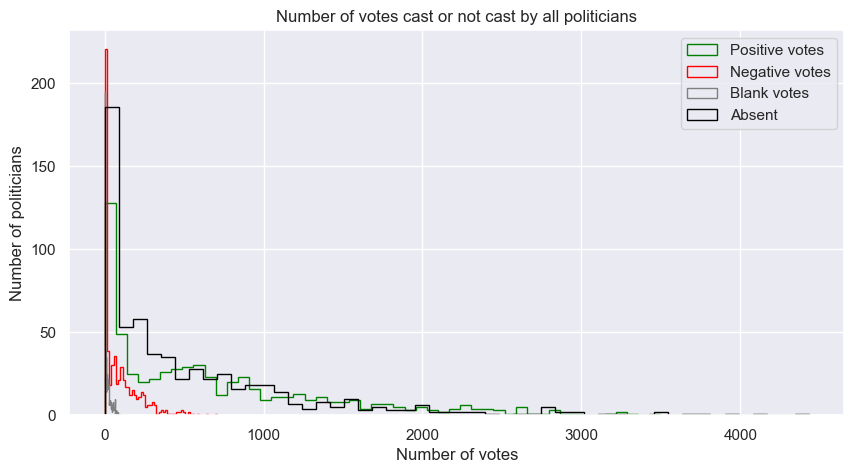

In [165]:
#Make a histogram of the number of votes cast by each politician
sns.set_theme(style="darkgrid", palette="deep", color_codes=True)
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(politician_votes['positive_votes'], bins=50, label='Positive votes', color = "green", histtype='step')
ax.hist(politician_votes['negative_votes'], bins=50, label='Negative votes', color = "red", histtype='step')
ax.hist(politician_votes['blank_votes'], bins=50, label='Blank votes', color = "grey", histtype='step')
ax.hist(politician_votes['absent'], bins=50, label='Absent', color = "black", histtype='step')
ax.legend()
ax.set_xlabel('Number of votes')
ax.set_ylabel('Number of politicians')
ax.set_title('Number of votes cast or not cast by all politicians')

In [149]:
#Save to pickle file
import pickle
with(open('clean_politician.pickle', 'wb')) as f:
    pickle.dump(clean_politician, f)

#Load from pickle file
#with(open('politician_votes.pickle', 'rb')) as f:
#    politician_votes = pickle.load(f)

In [119]:
test = get_politician(politician_votes["aktør_id"][0])

In [127]:
test['party']

'Danmarksdemokraterne'

In [106]:
politician_votes

,aktør_id,positive_votes,negative_votes,blank_votes,absent_votes
0,5,837,460,1167,65
1,12,283,16,2870,3
2,13,2,0,766,0
3,17,1532,215,1676,57
4,18,1390,336,1030,56
...,...,...,...,...,...
610,19948,35,4,12,0
611,19982,164,12,30,1
612,19996,4,0,5,0
613,20051,46,0,14,0


In [30]:
#politician_info = [get_politician(votes_df["votes_combined_info"][0][i]['id']) for i in range(len(votes_df["votes_combined_info"][0]))]

In [35]:
#converting list to dict
#politician_dict = pd.DataFrame.from_dict(politician_info)


In [41]:
#Makes the name of the laws distinguishable from the node names of the politicians
#ubset_votes["afstemnings_id"] = [str(num) + 'x' for num in subset_votes["afstemnings_id"].values]

C:\Users\rune7\AppData\Local\Temp\ipykernel_17004\1692368502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_votes["afstemnings_id"] = [str(num) + 'x' for num in subset_votes["afstemnings_id"].values]


In [57]:
subset_laws = law_info[0:100]



In [170]:
#getting vote info corresponding to the subset of laws
subset_votes = vote_info[vote_info["afstemnings_id"].isin(subset_laws['afstemnings_id'].values)]

In [168]:
politician_votes.head()

,aktør_id,positive_votes,negative_votes,blank_votes,absent,name,party
0,5,837,460,65,1167,Bent Bøgsted,Danmarksdemokraterne
1,12,283,16,3,2870,Jonas Dahl,Socialistisk Folkeparti
2,13,2,0,0,766,Lennart Damsbo-Andersen,Socialdemokratiet
3,17,1532,215,57,1676,Louise Schack Elholm,Venstre
4,18,1390,336,56,1030,Benny Engelbrecht,Socialdemokratiet


In [188]:
#Map politician id to name and party
for i in range(len(subset_votes["votes_combined_info"])):
    for j in range(len(subset_votes["votes_combined_info"][i])):
        aktør_id = subset_votes["votes_combined_info"][i][j]['aktørid']
        name = politician_votes.loc[politician_votes['aktør_id'] == aktør_id, 'name'].values[0]
        party = politician_votes.loc[politician_votes['aktør_id'] == aktør_id, 'party'].values[0]
        subset_votes['votes_combined_info'][i][j]['name'] = name
        subset_votes['votes_combined_info'][i][j]['party'] = party

In [194]:
#create a color map for the parties
import random
unique_parties = []
for i in range(len(subset_votes["votes_combined_info"])):
    for j in range(len(subset_votes["votes_combined_info"][i])):
        party = subset_votes['votes_combined_info'][i][j]['party']
        if party not in unique_parties:
            unique_parties.append(party)

#Create a color map for the parties
color_map = {}
for i in range(len(unique_parties)):
    color_map[unique_parties[i]] = (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))


In [195]:
color_map

{'Javnaðarflokkurin': (0.35548822648529343,
  0.33625099044734896,
  0.6931541735158542),
 'Moderaterne': (0.5277309521873825, 0.18623603343024742, 0.49601979195859836),
 'Dansk Folkeparti': (0.8591141254232184,
  0.5098915392637006,
  0.6529451848205834),
 'Socialdemokratiet': (0.6111949607897054,
  0.3640535103271051,
  0.9719592389921483),
 'Enhedslisten': (0.07630275847020018, 0.02494929577654148, 0.84509312267974),
 'Uden for folketingsgrupperne': (0.20169760503892598,
  0.004389490404442586,
  0.7388925366071307),
 'Venstre': (0.9586502473644917, 0.1025989547395526, 0.8219384547237555),
 'Socialistisk Folkeparti': (0.2328472928352835,
  0.43311638505351735,
  0.9509174915932249),
 'Radikale Venstre': (0.4439019923396895,
  0.9342293403848437,
  0.7943616010928265),
 'Liberal Alliance': (0.501235413325726,
  0.39187109507211326,
  0.3983706322862931),
 'Unknown': (0.6760930460035703, 0.5452258527232396, 0.7264442788155768),
 'Danmarksdemokraterne': (0.07639260164181783,
  0.935660

In [216]:
G = nx.Graph()
G.add_nodes_from(subset_laws['afstemnings_id'],bipartite=0, color = 'grey')
for i in range(len(subset_votes)):
    for j in range(len(subset_votes["votes_combined_info"][i])):
        party = subset_votes['votes_combined_info'][i][j]['party']
        G.add_node(subset_votes["votes_combined_info"][i][j]['name'], bipartite=1, color = color_map[party], party = party)
        if subset_votes["votes_combined_info"][i][j]['typeid'] == 1:
            G.add_edge(subset_votes["afstemnings_id"][i], subset_votes["votes_combined_info"][i][j]['name'], weight = 1)

In [215]:
G.nodes['Lars Løkke Rasmussen']['color']

(0.5277309521873825, 0.18623603343024742, 0.49601979195859836)

In [ ]:
#old one that works
# G = nx.Graph()
# G.add_nodes_from(subset_laws['afstemnings_id'],bipartite=0)
# for i in range(len(subset_votes)):
    
#     for j in range(len(subset_votes["votes_combined_info"][i])):
#         G.add_node(subset_votes["votes_combined_info"][i][j]['aktørid'], bipartite=1)
#         if subset_votes["votes_combined_info"][i][j]['typeid'] == 1:
#             G.add_edge(subset_votes["afstemnings_id"][i], subset_votes["votes_combined_info"][i][j]['aktørid'], weight = 1)

In [209]:

B = [node for node in G if node not in subset_laws['afstemnings_id'].values]

C:\Users\rune7\AppData\Local\Temp\ipykernel_17004\893472135.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  B = [node for node in G if node not in subset_laws['afstemnings_id'].values]


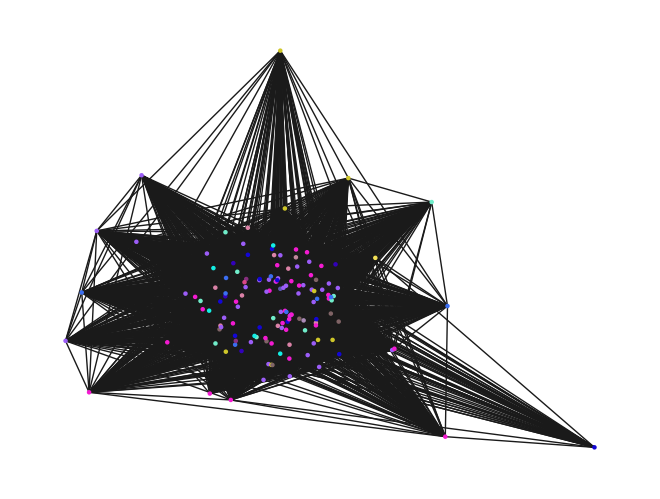

In [217]:
F = nx.bipartite.weighted_projected_graph(G, B)
F.remove_nodes_from(list(nx.isolates(F)))
nx.draw(F, node_size = 5,node_color = [G.nodes[node]['color'] for node in F.nodes], with_labels = False)

In [218]:
degree_list = []
for node in F.nodes():
    degree_list.append(F.degree(node))

# normalize node size to highest degree with max size = 30
max_degree = max(degree_list)
node_size_list = [x/max_degree*200 for x in degree_list]

In [219]:
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt

100%|██████████| 500/500 [00:00<00:00, 1032.37it/s]


BarnesHut Approximation  took  0.05  seconds
Repulsion forces  took  0.33  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


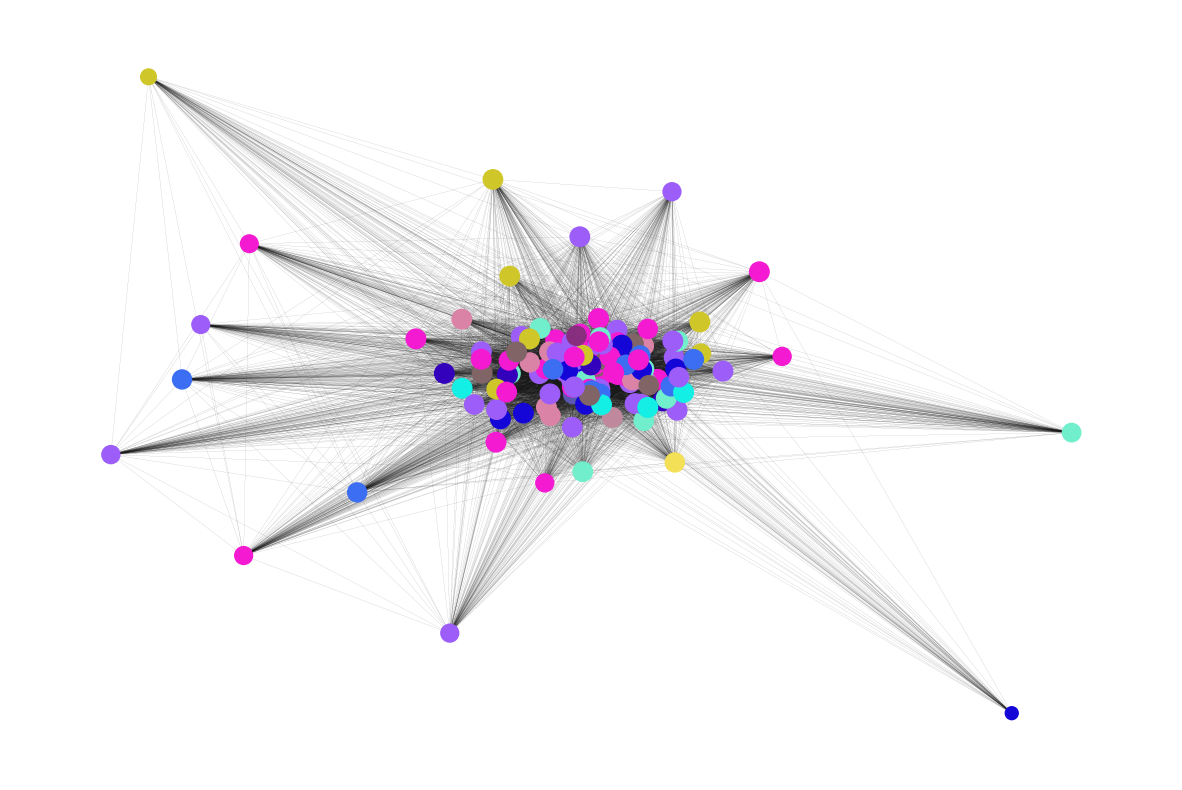

In [244]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1,

    # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1,
                        strongGravityMode=True,
                        gravity=5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(
    F, pos=None, iterations=500)

fig, ax = plt.subplots(figsize=(15, 10))
nx.draw(F, pos=positions, with_labels=False, node_size=node_size_list, node_color = [G.nodes[node]['color'] for node in F.nodes],
        width=0.05)
